# Verification results notebook
This notebook can optionally run a batch of tests in which all the selected implementations across backends and possibly devices are compared against a reference implementation on a distribution of initial conditions.

I decided to include the test runs inside the notebook. This way I can:
  * control the experiments from a single source of truth
  * put in the same file the generation of the dataset and its processing (although the generation could be "cached")
  * possibly connect with remote devices (with Jupyter remote server) and collect interesting data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# these are the columns of the dataset we will study
COLUMNS = [
    'algorithm',
    'name',
    'backend',
    'device',
    'dtype',
    'seed',
    'abs_err',
    'rel_err',
    'transfer_time',
    'compute_time',
]

## Test runner implementation

In [3]:
import jax
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)
import numpy as np

from slmporting.core.slm import SLM
from slmporting.core.array import Array
from slmporting.core.types import Algorithm, Backend, Device, DType

In [4]:
# functions to manage the rng state, the user initializes the rng from an integer
# these functions must be exported because other experiments share the same functionality
def key_to_int(key):
    """Combine two uint32 values into a single 64-bit integer seed."""
    return int(key[0]) << 32 | int(key[1])


def int_to_key(seed):
    """Recreate the PRNGKey from the integer seed."""
    upper = (seed >> 32) & 0xFFFFFFFF
    lower = seed & 0xFFFFFFFF
    return jnp.array([upper, lower], dtype=jnp.uint32)


def generate_input_data(key, n: int):
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, 4)

    x     = Array(jax.random.uniform(subkeys[0], n, minval=-50.0, maxval=50.0))
    y     = Array(jax.random.uniform(subkeys[1], n, minval=-50.0, maxval=50.0))
    z     = Array(jax.random.uniform(subkeys[2], n, minval=-5.0 , maxval=5.0))
    pists = Array(jax.random.uniform(subkeys[3], n, minval=0.0  , maxval=1.0))

    return (key, subkey), (x, y, z, pists)

In [5]:
import itertools
import slmporting.impl.impl_numpy
import slmporting.impl.impl_jax
import slmporting.impl.impl_torch
import slmporting.impl.impl_cpp

# function for filtering the implementations based on
#   * requested backends
#   * requested devices
def filter_implementations(
        requested_algorithm: list,
        requested_backends: list):

    def filter_fcn(impl):
        return (impl.backend in requested_backends) and \
               (impl.algorithm in requested_algorithm)

    all_implementations = itertools.chain(
        slmporting.impl.impl_numpy.IMPLS,
        slmporting.impl.impl_jax.IMPLS,
        slmporting.impl.impl_torch.IMPLS,
        slmporting.impl.impl_cpp.IMPLS,
    )

    return list(filter(filter_fcn, all_implementations))

In [6]:
# we are dealing with a number that lives in [0, 2π]
# and wraps, so 2π-ε and ε are quite close
def abs_error_function(x, y):
    return np.max(np.abs(x-y))

def rel_error_function(x, y):
    return np.max(np.abs((x-y)/x))

In [7]:
from tqdm.notebook import tqdm

# this test is made only for CPU devices,
# but it should be extended for GPU use
def run_test_batch(
    seed: int,
    nruns: int,
    requested_backends = [
        Backend.NUMPY,
        Backend.JAX,
        Backend.TORCH,
        Backend.CPP,
    ],
    nspots: int = 100) -> pd.DataFrame:

    key = int_to_key(seed)
    slm = SLM.get_standard_slm()

    algorithm = Algorithm.RS
    matching_implementations = [
        impl()
        for impl in filter_implementations(
            [algorithm],
            requested_backends,
        )
    ]
    assert(len(matching_implementations) > 0)

    # the structure where I push the experiment data,
    # to be later transformed into a pandas dataframe
    acc = []

    for run_idx in tqdm(range(nruns)):
        (key, subkey), (x, y, z, pists) = generate_input_data(key, nspots)

        reference_impl = matching_implementations[0]
        reference_phase, _ = reference_impl(x, y, z, pists, slm)

        for impl in matching_implementations:
            assert(impl.algorithm == algorithm)
            alternative_phase, times = impl(x, y, z, pists, slm)

            total_time = times.transfer_time + times.compute_time

            acc.append((
                algorithm,
                impl.name,
                impl.backend,
                Device.CPU,
                DType.fp64,
                key_to_int(key),
                abs_error_function(reference_phase, alternative_phase),
                rel_error_function(reference_phase, alternative_phase),
                times.transfer_time,
                times.compute_time
            ))

    return pd.DataFrame(acc, columns=COLUMNS)

## Optional test execution

This notebook is meant to be executed on:
  * my working laptop
  * a google colab environment
  * my computing cluster

I propose the use of environment variables that override the notebook execution parameters. This way I can remotely execute a complete notebook without any manual intervention. This is a snippet for starting an asynchronous jupyter notebook:

```bash
nohup jupyter nbconvert --to notebook --execute verification.ipynb --output result.ipynb > notebook.log 2>&1 &
```

In [8]:
import os

def get_notebook_execution_parameters(
    csv_filename: str,
    seed: int,
    nruns: int,
):
    csv_filename = os.environ.get('SLM_OUTPUT_CSV') or csv_filename
    seed = os.environ.get('SLM_SEED') or seed
    nruns = os.environ.get('SLM_NRUNS') or nruns

    return csv_filename, seed, nruns

In [9]:
csv_filename, seed, nruns = get_notebook_execution_parameters(
    csv_filename='results/hp_laptop.csv',
    seed=99,
    nruns=100
)

In [10]:
try:
    df = pd.read_csv(csv_filename)
except FileNotFoundError:
    df = run_test_batch(seed, nruns)
    df.to_csv(csv_filename, index=False)

/home/matteo/github/slm-porting/venv/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/100 [00:00<?, ?it/s]

/home/matteo/github/slm-porting/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
W1028 10:22:23.973000 13334 torch/utils/cpp_extension.py:117] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr'


## Data analysis

### Preprocessing

In [11]:
df['total_time'] = df['transfer_time'] + df['compute_time']

In [12]:
# those columns are enums, not strings. I convert them into strings
# so that the further processing follows a more traditional workflow
for column_name in ['algorithm', 'backend', 'device', 'dtype']:
    df[column_name] = df[column_name].apply(
        lambda a: str(a).split('.')[-1]
    )

In [13]:
# In the following analyses I need to group the data by backend
# and then by implementation name.
grouped_by_backend = df.groupby('backend')

In [14]:
backend_color_map = {
    'NUMPY': '#568df5',
    'JAX': '#52fa85',
    'TORCH': '#fa6b52',
    'CPP': '#2617ff'
}

In [15]:
df.head(n=10)

,algorithm,name,backend,device,dtype,seed,abs_err,rel_err,transfer_time,compute_time,total_time
0,RS,rs,NUMPY,CPU,fp64,10350481614395321474,0.000000e+00,0.000000e+00,0.000132,0.563160,0.563293
1,RS,rs_no_complex,NUMPY,CPU,fp64,10350481614395321474,4.440892e-16,3.936921e-16,0.000179,0.450990,0.451169
2,RS,rs,JAX,CPU,fp64,10350481614395321474,3.167910e-12,1.714339e-09,0.000586,0.167671,0.168258
3,RS,rs_no_complex,JAX,CPU,fp64,10350481614395321474,3.167910e-12,1.714339e-09,0.000894,0.336545,0.337439
4,RS,rs_vmap,JAX,CPU,fp64,10350481614395321474,3.013589e-12,2.272637e-09,0.000534,0.210408,0.210942
5,RS,rs,TORCH,CPU,fp64,10350481614395321474,1.247891e-13,6.095896e-12,0.000176,1.943525,1.943701
6,RS,rs_no_complex,TORCH,CPU,fp64,10350481614395321474,5.417888e-14,6.095730e-12,0.000274,0.152222,0.152496
7,RS,rs,CPP,CPU,fp64,10350481614395321474,3.027800e-12,2.151268e-09,0.000261,0.023109,0.023370
8,RS,rs_simd,CPP,CPU,fp64,10350481614395321474,5.399237e-12,4.612056e-10,0.000234,0.022460,0.022695
9,RS,rs_simulated_simd,CPP,CPU,fp64,10350481614395321474,3.142819e-12,2.221056e-09,0.000293,0.066152,0.066444


### Error distribution
Considering only CPU implementations:
  * what is the distribution of the error, among the backends and the single implementations?
  * are there any outliers in the error?
  * what is the most precise implementation for each backend?

In [16]:
local = df[
    (df['device'] == 'CPU') &
    (df['abs_err'] > 0) &
    (df['dtype'] == 'fp64')
]

local['log10_err'] = np.log10(local['rel_err'])

/tmp/ipykernel_13334/3491816441.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local['log10_err'] = np.log10(local['rel_err'])


In [17]:
# now we need to group the dataset with pairs (backend, name)
# since I can't groupby two columns, I have to build a dictionary
# of dictionaries
grouped_by_backend_then_by_name = {}

for backend, df_by_backend in local.groupby('backend'):
    grouped_by_backend_then_by_name[backend] = {
        name: df_by_backend_and_name['log10_err']
        for name, df_by_backend_and_name in df_by_backend.groupby('name')
    }

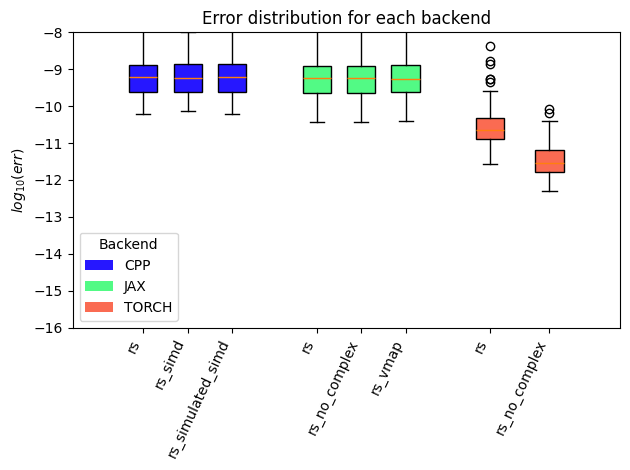

In [18]:
# this is a sophisticated type of plot
# I need to group visualizations based on the backend,
fig, ax = plt.subplots()

bar_width = 0.2
intra_gap = 0.01
group_gap = 0.6

offset = 0.0
x_positions = []
x_labels = []

for backend, grouped_by_name in grouped_by_backend_then_by_name.items():
    # the numpy implementation is only used as a reference, so it's not very interesting
    if backend == 'NUMPY':
        continue

    color = backend_color_map[backend]
    positions = np.linspace(offset, offset + len(grouped_by_name) * (bar_width + intra_gap), num=len(grouped_by_name))

    ax.boxplot(
        grouped_by_name.values(),
        positions=positions,
        widths=bar_width,
        patch_artist=True,
        boxprops=dict(facecolor=color, color='black'),
    )
    ax.bar(0, 0, color=color, label=backend)

    for name in grouped_by_name.keys():
        x_labels.append(name)

    x_positions.extend(positions)
    offset = positions[-1] + group_gap

ax.set_title('Error distribution for each backend')
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=65, ha='right')
ax.set_ylim((-16.0, -8.0))
ax.set_ylabel('$log_{10}(err)$')
ax.legend(title="Backend")

plt.tight_layout()
plt.show()

The numpy implementation was the reference in this experiment, so it's normal that its absolute error is the lowest. The other implementations could have introduced errors by:
  * calling lower precision variants of trigonometric functions
  * implementing a different reduction strategy for the plus operator

The phase is uniformely distributed in $[0, 2 \pi]$ so this kind of errors don't scare me. This is primarely a test for buggy implementations and fortunately there are no outliers here.

In [19]:
# we finally produce a record of the best implementations (based on the median error)
# for a given backend
best_implementations_for_log10_error = []

for backend, grouped_by_name in grouped_by_backend_then_by_name.items():
    best = min(
        map(
            lambda p: (p[0], np.median(p[1])),
            grouped_by_name.items()
        ),
        key = lambda p: np.median(p[-1])
    )
    best_implementations_for_log10_error.append((backend, *best))

best_implementations_for_log10_error

[('CPP', 'rs_simd', np.float64(-9.235824896029051)),
 ('JAX', 'rs_vmap', np.float64(-9.259206920481146)),
 ('NUMPY', 'rs_no_complex', np.float64(-15.399517353539103)),
 ('TORCH', 'rs_no_complex', np.float64(-11.53618876514913))]

In [20]:
list(zip(*best_implementations_for_log10_error))

[('CPP', 'JAX', 'NUMPY', 'TORCH'),
 ('rs_simd', 'rs_vmap', 'rs_no_complex', 'rs_no_complex'),
 (np.float64(-9.235824896029051),
  np.float64(-9.259206920481146),
  np.float64(-15.399517353539103),
  np.float64(-11.53618876514913))]

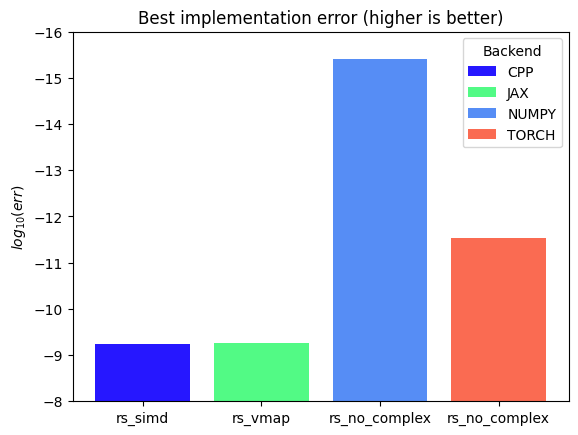

In [21]:
fig, ax = plt.subplots()

backends, names, median_log10_errors = list(
    zip(*best_implementations_for_log10_error)
)

x_positions = np.arange(len(names))
ax.bar(
    x_positions,
    median_log10_errors,
    color=[
        backend_color_map[b]
        for b in backends
    ],
    label=backends
)

ax.set_xticks(x_positions)
ax.set_xticklabels(names)

ax.set_title("Best implementation error (higher is better)")
ax.set_ylim((-16.0, -8.0))
ax.set_ylabel('$log_{10}(err)$')
ax.yaxis.set_inverted(True)
ax.legend(title='Backend')

plt.show()

### Performance
The data campaign doesn't specifically test for performance as it will be very wasteful to profile a known bad implementation. From this data we can screen for the best implementation in each category, then we can inform more accurate test pipelines.

We can reuse the same grouped comparison plots for the runtime plots. Speedup plots are required.

In [22]:
local = df[
    (df['algorithm'] == 'RS') &
    (df['device'] == 'CPU') &
    (df['dtype'] == 'fp64')
]

In [23]:
grouped_by_backend_then_by_name = {}

for backend, df_by_backend in local.groupby('backend'):
    grouped_by_backend_then_by_name[backend] = {
        name: df_by_backend_and_name['total_time']
        for name, df_by_backend_and_name in df_by_backend.groupby('name')
    }

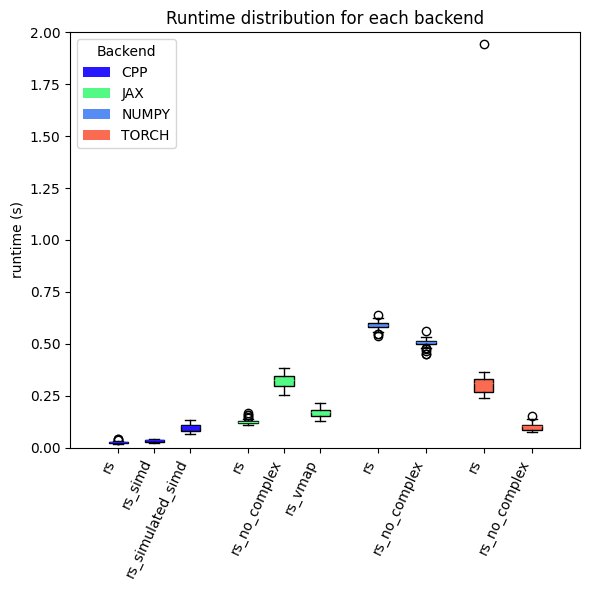

In [24]:
fig, ax = plt.subplots(figsize=(6,6))

# plotting parameters, for decoration
bar_width = 0.2
intra_gap = 0.05
group_gap = 0.6

offset = 0.0
x_positions = []
x_labels = []

for backend, grouped_by_name in grouped_by_backend_then_by_name.items():
    color = backend_color_map[backend]
    positions = np.linspace(offset, offset + len(grouped_by_name) * (bar_width + intra_gap), num=len(grouped_by_name))

    ax.boxplot(
        grouped_by_name.values(),
        positions=positions,
        widths=bar_width,
        patch_artist=True,
        boxprops=dict(facecolor=color, color='black'),
        medianprops=dict(color=color),
    )
    ax.bar(0, 0, color=color, label=backend)

    for name in grouped_by_name.keys():
        x_labels.append(name)

    x_positions.extend(positions)
    offset = positions[-1] + group_gap

ax.set_title('Runtime distribution for each backend')
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=65, ha='right')
ax.set_ylim((0.0, 2.0))
ax.set_ylabel('runtime (s)')
ax.legend(title="Backend")

plt.tight_layout()
plt.show()

The big variability in the torch version of `rs` is due to:
  * JIT compilation
  * torch non fully supporting complex numbers operations

I'm happy that my C++ implementations beat pytorch. This means that I'll still have a job in the future.

In [25]:
# we finally produce a record of the best implementations (based on the median runtime)
# for a given backend
best_implementations_for_runtime = []

for backend, grouped_by_name in grouped_by_backend_then_by_name.items():
    best = min(
        map(
            lambda p: (p[0], np.median(p[1])),
            grouped_by_name.items()
        ),
        key = lambda p: np.median(p[-1])
    )
    best_implementations_for_runtime.append((backend, *best))

best_implementations_for_runtime

[('CPP', 'rs', np.float64(0.02542922449993057)),
 ('JAX', 'rs', np.float64(0.12159152399999584)),
 ('NUMPY', 'rs_no_complex', np.float64(0.5058575989996825)),
 ('TORCH', 'rs_no_complex', np.float64(0.1044985774997258))]

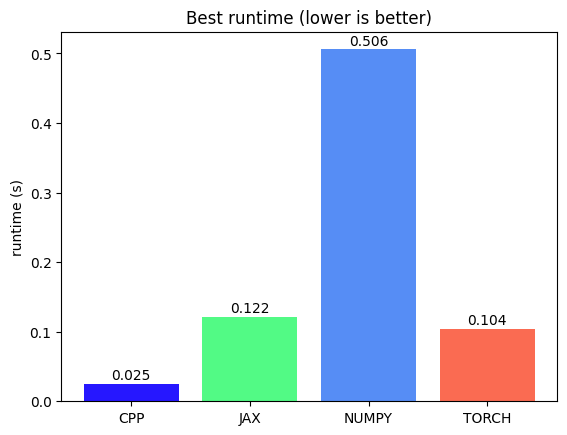

In [26]:
fig, ax = plt.subplots()

backends, names, median_runtime = list(
    zip(*best_implementations_for_runtime)
)

bars = ax.bar(
    backends,
    median_runtime,
    color=[
        backend_color_map[b]
        for b in backends
    ],
)

ax.set_title("Best runtime (lower is better)")
ax.set_ylabel('runtime (s)')

ax.bar_label(
    bars,
    labels=[f"{v:.3f}" for v in median_runtime],
    padding=1
)

plt.show()

You can find the name of the best implementations for each backend in a previous cell. I didn't but in the plot because of readability.

The best C++ implementation is the original one. I didn't use any fancy technique, and probably the difference with pytorch is because of a strange behaviour when linking with OpenMP. It seems that the pytorch runtime already has OpenMP symbols, but are not really efficient. When I produce the C++ library with proper OpenMP flags I get a CMake error on the compilation, but a boost in performance.

In [27]:
backend_to_runtime_map = {
    backend: runtime
    for backend, name, runtime in best_implementations_for_runtime
}

speedup_to_numpy = {
    backend: backend_to_runtime_map['NUMPY'] / runtime
    for backend, runtime in backend_to_runtime_map.items()
}

speedup_to_torch = {
    backend: backend_to_runtime_map['TORCH'] / runtime
    for backend, runtime in backend_to_runtime_map.items()
}

In [28]:
def plot_speedup_to_x(backend_to_runtime_map, x: str):
    speedup_to_x = {
        backend: backend_to_runtime_map[x] / runtime
        for backend, runtime in backend_to_runtime_map.items()
    }

    fig, ax = plt.subplots()

    bars = ax.bar(
        speedup_to_x.keys(),
        speedup_to_x.values(),
        color=[
            backend_color_map[b]
            for b in backends
        ],
    )

    ax.set_title(f"Speedup to {x} ({csv_filename})")
    ax.set_ylabel('speedup')

    ax.bar_label(
        bars,
        labels=[f"{v:.1f}x" for v in speedup_to_x.values()],
        padding=1
    )

    plt.show()

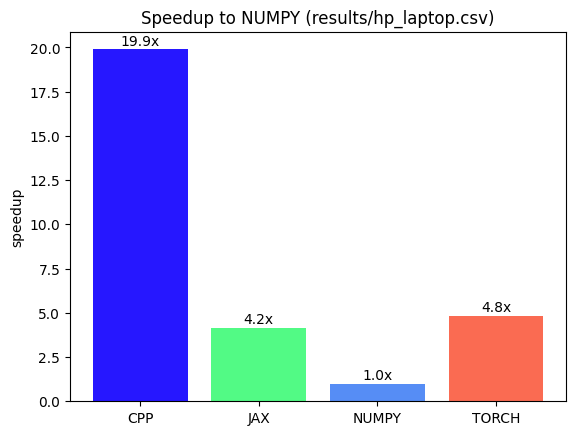

In [29]:
plot_speedup_to_x(backend_to_runtime_map, 'NUMPY')

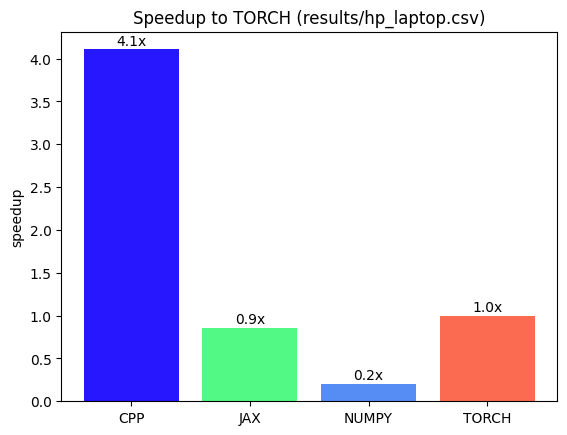

In [30]:
plot_speedup_to_x(backend_to_runtime_map, 'TORCH')